In [3]:
# importing eseential packages
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
import numpy as np
from torch.utils.data import Dataset,DataLoader
from sklearn.metrics import accuracy_score
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import spacy
import simpletransformers
from simpletransformers.language_representation import RepresentationModel
from scipy import stats
import scipy
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

Loading the Data

In [5]:

df_train = pd.read_csv('splits/train_ids.txt', header = None).reset_index(drop=True)
df_valid = pd.read_csv('splits/val_ids.txt', header = None).reset_index(drop=True)
df_test = pd.read_csv('splits/test_ids.txt', header = None).reset_index(drop=True)
mapping = pd.read_json('MMHS150K_GT.json').T
mapping['id'] = mapping['tweet_url'].apply(lambda x : int(x.split('/')[-1]))
mapping = mapping[mapping['labels'].apply(lambda x: len(x)) == 3]
def get_mode_labels(array):
  output = scipy.stats.mode(array, axis = 0)[0][0]
  if output:
    return 1
  else:
    return 0  
mapping['new_labels'] = mapping['labels'].map(lambda x: get_mode_labels(x))

In [6]:
mapping = mapping[:14000]

Data Exploration

In [7]:
not_hate = mapping['new_labels'].value_counts()[0]/sum(mapping['new_labels'].value_counts())
hate = mapping['new_labels'].value_counts()[1]/sum(mapping['new_labels'].value_counts())

In [8]:
new_label_df = mapping.groupby(by = 'new_labels').count().reset_index()[['new_labels', 'id']]

In [9]:
new_label_df['labels'] = np.where(new_label_df['new_labels'] == 0, 'Not Hate', 'Hate')

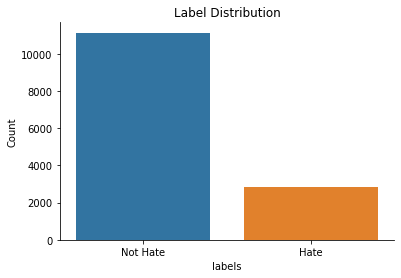

In [10]:
ax = sns.barplot(x = 'labels', y = 'id', data =  new_label_df)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('Count')
ax.set_title('Label Distribution')
plt.show()

In [11]:
mapping['new_labels'].value_counts()

0    11147
1     2853
Name: new_labels, dtype: int64

In [12]:
11147/2853

3.9071153172099544

In [13]:
df_train = df_train.merge(mapping, left_on = 0, right_on = 'id', how = 'inner' )[0]
df_valid = df_valid.merge(mapping, left_on = 0, right_on = 'id' )[0]
df_test = df_test.merge(mapping, left_on = 0, right_on = 'id' )[0]

In [14]:
df_train

0        1108732814202228737
1        1115098114485096450
2        1115415058127970305
3        1055991175197401088
4        1061527109577785344
                ...         
10042    1115356440003133441
10043    1107378909602033664
10044    1106712950629371905
10045    1110265873317670912
10046    1108990126334586881
Name: 0, Length: 10047, dtype: int64

Creating dataset and dataloader

In [15]:
class ImageDataset(Dataset):
    def __init__(self, ids):
        self.ids = ids
        self.transpose = A.Compose([
                # pixel-level transformation
                A.RandomBrightnessContrast(p=0.3),
                
                # we will normalize according to ImageNet since we will be using a pre-trained ResNet
                # this adjusts from [0,255] to [0,1]
                A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                
                # convert to a tensor and move color channels
                ToTensorV2()
            ])

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        try:
            file_name = self.ids[idx]
            img = cv2.imread('img_resized/'+str(file_name)+'.jpg')
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img,(224,224))
            img = self.transpose(image=img.astype(np.uint8))['image']

            y = torch.tensor(mapping[mapping['id'] == file_name]['new_labels'].values)
            
            return img.to(device).float(),y.squeeze().to(device).float()
        except:
            print(y)

    

In [16]:
batch_size = 320

train_ds = ImageDataset(df_train)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

valid_ds = ImageDataset(df_valid)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=True)

test_ds = ImageDataset(df_test)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=True)

Modelling

In [25]:
# Loading Resnet
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True).to(device)


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [26]:
# final model used to process input image

class ImageCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(1000, 50)
        self.linear2 = nn.Linear(50,1)
        
    def forward(self, feat):
        feat = model(feat)
        x = feat
        x = F.relu(self.linear1(x))
        x = self.linear2(x)   
        return x
    
net = ImageCNN().to(device)

In [27]:
def valid_metrics(model, test_dl):
    """Computes validation loss and accuracy"""
    with torch.no_grad():
        model.eval()
        total_loss = []
        total_acc = []
        ### BEGIN SOLUTION
        for feat, y1 in tqdm(test_dl):
            
            y_hat1 = model(feat).squeeze()
            pos_weight = torch.tensor([4 if el == 1 else 1 for el in y1]).to(device)
            train_loss = F.binary_cross_entropy_with_logits(y_hat1, y1, pos_weight = pos_weight)
          
            # valid_acc = accuracy_score(y1.cpu(),dim=-1),torch.argmax(F.log_softmax(y_hat1,dim=-1).cpu(),axis=1))
            valid_acc = (np.array(y1.cpu())== np.around(torch.sigmoid(y_hat1).cpu().detach().numpy())).sum()/len(y1.cpu())
            total_loss.append(train_loss.item())
            total_acc.append(valid_acc)
        
        ### END SOLUTION
        return np.mean(total_loss), np.mean(total_acc)



def train_one_epoch(model, train_dl, optimizer):
    """ Trains the model for one epoch"""
    model.train()

    for feat,y1 in tqdm(train_dl):
        pos_weight = torch.tensor([4 if el == 1 else 1 for el in y1]).to(device)
        y_hat1 = model(feat).squeeze()     
        train_loss = F.binary_cross_entropy_with_logits(y_hat1, y1, pos_weight = pos_weight)
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
    
    loss, acc = valid_metrics(model, train_dl)
    
    return loss, acc

def training(model, train_dl, test_dl, epochs=10, lr=1e-4, wd=0.0):
    optimizer = torch.optim.Adam(net.parameters(), lr = lr, weight_decay = wd)
    for i in range(epochs):
        print('-'*40,'epoch: ',i+1,'-'*40)
        train_loss, train_acc = train_one_epoch(model, train_dl, optimizer)
        test_loss, test_acc = valid_metrics(model, test_dl) 
        print("train acc %.3f test acc %.3f" % (train_acc, test_acc))
        print(f"train_loss {train_loss} test_loss {test_loss}") 

Training the model

In [28]:

training(net, train_dl,valid_dl,epochs = 5, lr = 1e-3, wd = 0)

---------------------------------------- epoch:  1 ----------------------------------------


100%|██████████| 6/6 [00:13<00:00,  2.20s/it]


train acc 0.860 test acc 0.518
train_loss 0.900509987026453 test_loss 2.28530224164327
---------------------------------------- epoch:  2 ----------------------------------------


100%|██████████| 6/6 [00:13<00:00,  2.19s/it]


train acc 0.835 test acc 0.511
train_loss 0.8754713255912066 test_loss 2.100468913714091
---------------------------------------- epoch:  3 ----------------------------------------


100%|██████████| 6/6 [00:13<00:00,  2.20s/it]


train acc 0.812 test acc 0.507
train_loss 0.848966907709837 test_loss 2.2179279724756875
---------------------------------------- epoch:  4 ----------------------------------------


100%|██████████| 6/6 [00:13<00:00,  2.22s/it]


train acc 0.838 test acc 0.515
train_loss 0.8265326283872128 test_loss 2.267032504081726
---------------------------------------- epoch:  5 ----------------------------------------


100%|██████████| 6/6 [00:13<00:00,  2.20s/it]

train acc 0.836 test acc 0.517
train_loss 0.7976903710514307 test_loss 2.4094889163970947
